# Quick start for binary classification using _ImaGene_

Tutorial to perform a binary classification using _ImaGene_. The aim is to classify whether a gene is under positive selection or neutrally evolving.

The first step is to generate training and testing datasets. This is accomplished using _msms_. An example on how to do this is given in the script below. This script will split the simulations into different batches to later perform training with a "simulation-on-the-fly" approach.

In [ ]:
# bash Reproduce/generate_data.sh Binary

Load the necessary modules in _python_.

In [1]:
import os
import gzip
import _pickle as pickle

import numpy as np
import scipy.stats

import skimage.transform
from keras import models, layers, activations, optimizers, regularizers
from keras.utils import plot_model
from keras.models import load_model

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pydot # optional, but required by keras to plot the model 

Using TensorFlow backend.


This tutorial has been tested with:
* python 3.6.8
* numpy 1.16.3
* scipy 1.2.1
* keras 2.2.4
* tensorflow 1.13.1
* scikit-image              0.15.0
* scikit-learn              0.20.3
* matplotlib                3.0.3
* pydot                     1.4.1

In [2]:
%run -i ImaGene.py

Let's perform the first iteration of training.

To do that, the first thing to do is to read the first batch of simulations and store them into an _ImaFile_ object. We assume we have 128 samples (haplotypes) using a 3-epoch demographic model for Europeans.

In [3]:
myfile = ImaFile(simulations_folder='/home/mfumagal/Data/ImaGene/Binary/Simulations1.Epoch3', nr_samples=128, model_name='Marth-3epoch-CEU')

Then, we populate an _ImaGene_ object by selection the variabile we want to estimate/predict ('selection_coeff_hetero') and how many data points per class we wish to retain. As a quick example, we will use only 2000 data points per class.

In [4]:
mygene = myfile.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=2000)

We can have a look at the data stored in this object.

In [5]:
mygene.summary()

An object of 100 images
Rows: min 128, max 128, mean 128.000000, std 0.000000
Columns: min 125, max 397, mean 250.790000, std 56.518899


0

It looks like we have 10000 images in this object. Recall that with the first line we simulated 5 classes and retain 2000 data points for each class. All images have 128 rows as expected, as this represents the number of simulated haplotypes. However, images have different number of columns, ranging from 110 to 422 with an average value of around 257. The number of columns represents the number of polymorphic sites and fixed derived alleles in a _msms_ file. This number may vary from simulated image to another.

We can also check the sample allele frequency for the selected allele. recall that we imposed selection to be acting in the middle of the region. Therefore, the targeted allele will be in position '0.5' in the _msms_ file.

Text(0, 0.5, 'Allele frequency')

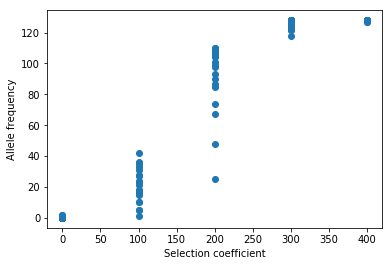

In [6]:
freqs = calculate_allele_frequency(mygene, 0.5)
plt.scatter(mygene.targets, freqs, marker='o')
plt.xlabel('Selection coefficient')
plt.ylabel('Allele frequency')

As you can see, the current allele frequency for the targeted allele (on the y-axis) tends to increase for increasing selection coefficient (on the x-axis).

Next, _ImaGene_ provides functionalities to manipulate our object. Specifically we can do the following:
* convert ancestral/derived to major/minor allele polarisation
* filter out columns based on a minimum allele frequency (e.g. 0.01)
* sorting rows and columns by frequency (or distance from the most frequent entry)
* resize rows and columns (e.g. to 128x128)

For instance, the options above could be achieved with the following lines:

In [ ]:
mygene.majorminor()
mygene.filter_freq(0.01)
mygene.sort('rows_freq')
mygene.sort('cols_freq')
mygene.resize((128, 128))

After the data manipulation is done, we have to convert images to proper _numpy_ float matrices. The following line will do the job. Note that this '.convert' method allows you to normalise the data too.

In [ ]:
mygene.convert(verbose=True)

As an illustration, let's plot one image per class. We can also check the new data dimensions.

In [ ]:
for sel in mygene.classes:
    print(sel)
    mygene.plot(np.where(mygene.targets == sel)[0][0])
mygene.summary()

Let's suppose that we want to do a simple binary classification. This means that we only want to consider 2 classes. For doing that, first we need to set '.classes' to the desired values and then we need to take a subset of the data corresponding to the desired classes only.

We cam achieve these steps with the following lines.

In [ ]:
mygene.classes = np.array([0,300])
classes_idx = get_index_classes(mygene.targets, mygene.classes)
len(classes_idx)

As you can see, we now have 4000 data points, as expected. Finally, let's take the corresponding subset of the data.

In [ ]:
mygene.subset(classes_idx)
mygene.summary()

Now we have an object of 4000 data points (images). 

The next thing to do is very important. We need to randomly shuffle our retained images before using them for training our network.

In [ ]:
rnd_idx = get_index_random(mygene)
mygene.subset(rnd_idx)

At the moment our targets represent the 2 possible classes. However, since we are doing a binary classification, we need to vectorise them as required by _keras_.

In [ ]:
mygene.targets = to_binary(mygene.targets)

The object is now ready to be used for the classification!
You can save it.

In [ ]:
mygene.save(file='mygene')

If you want to load an _ImaGene_ object you can use the following function:

In [ ]:
mygene = load_imagene(file='mygene')

Now that our data is ready, we can build our network.
Specifically, we can build a model in _keras_ with convolutional, pooling and dense layers.

In [ ]:
model = models.Sequential([
                    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid', input_shape=mygene.data.shape[1:4]),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Flatten(),
                    layers.Dense(units=64, activation='relu'),
                    layers.Dense(units=1, activation='sigmoid')])

Then, let's compile our _keras_ model.

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Let's look at a summary of the model and plot it.

In [ ]:
model.summary()
plot_model(model, 'net.png')

Now we are ready for doing the training on this first batch of data.

In [ ]:
score = model.fit(mygene.data, mygene.targets, batch_size=32, epochs=1, verbose=1, validation_split=0.10)

Recall that you can save a _keras_ model with `model.save('net.h5')`.

Now we can initialise a network object _ImaNet_.

In [ ]:
mynet = ImaNet(name='[C32+P]x3+D64')

We can keep track of scores (loss and accuracy) across iterations with '.update_scores'.

In [ ]:
mynet.update_scores(score)

OK, now we can repeat the whole procedure described above using all remaning batches of data, leaving the last one for testing.

In [ ]:
i = 2
while i < 10:

    print(i)
    
    myfile = ImaFile(simulations_folder='/home/mfumagal/Data/ImaGene/Binary/Simulations' + str(i) + '.Epoch3', nr_samples=128, model_name='Marth-3epoch-CEU')
    mygene = myfile.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=2000)

    mygene.majorminor()
    mygene.filter_freq(0.01)
    mygene.sort('rows_freq')
    mygene.sort('cols_freq')
    mygene.resize((128, 128))
    mygene.convert()

    mygene.classes = np.array([0,300])
    mygene.subset(get_index_classes(mygene.targets, mygene.classes))
    mygene.subset(get_index_random(mygene))

    mygene.targets = to_binary(mygene.targets)
     
    score = model.fit(mygene.data, mygene.targets, batch_size=32, epochs=1, verbose=1, validation_split=0.10)
    mynet.update_scores(score)
   
    i += 1

We can plot loss and validation accuracy during the training to check, for instance, for overfitting.

In [ ]:
mynet.plot_train()

We save (and/or load) the final trained model.

In [ ]:
model.save('net.h5')

In [ ]:
model = load_model('net.h5')

Finally, we evaluate the training on the testing dataset, i.e. the last batch of simulated data.

In [ ]:
i = 10
myfile = ImaFile(simulations_folder='/home/mfumagal/Data/ImaGene/Binary/Simulations' + str(i) + '.Epoch3', nr_samples=128, model_name='Marth-3epoch-CEU')
mygene_test = myfile.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=2000)

mygene_test.majorminor()
mygene_test.filter_freq(0.01)
mygene_test.sort('rows_freq')
mygene_test.sort('cols_freq')
mygene_test.resize((128, 128))
mygene_test.convert()

mygene_test.classes = np.array([0,300])
classes_idx = get_index_classes(mygene_test.targets, mygene_test.classes)
mygene_test.subset(classes_idx)
rnd_idx = get_index_random(mygene_test)
mygene_test.subset(rnd_idx)

mygene_test.targets = to_binary(mygene_test.targets)

Let's report loss and accuracy on the testing set.

In [ ]:
mynet.test = model.evaluate(mygene_test.data, mygene_test.targets, batch_size=None, verbose=0)
print(mynet.test)

For a binary or multiclass classification, it is convenient to plot the confusion matrix after predicting the responses from the testing data.

In [ ]:
mynet.predict(mygene_test, model)

In [ ]:
mynet.plot_cm(mygene_test.classes)

For the estimation of continuous variabiles, we can produce a scatter plot with `mynet.plot_scatter()`.